<a href="https://colab.research.google.com/github/SilentStoneCA/papercode/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
#def prepare(ds, shuffle=False, augment=False):


In [ ]:
!pip install wandb

In [3]:
import wandb
wandb.init()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
def load_data(batch_size, resize):
  rescale_fn = tf.keras.Sequential ([
    tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255.)
  ])

  resize_fn = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(resize, resize)                         
  ])

  augment_fn = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1), 
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.Lambda(lambda x : tf.image.stateless_random_brightness(x, 0.1, (1,2))) 
  ])

  data_set = tf.keras.datasets.cifar10
  train, test = data_set.load_data()
  rescale = lambda X, Y: (rescale_fn(X, training=True), Y)
  return (tf.data.Dataset.from_tensor_slices(rescale(*train)).batch(batch_size)
                                                                .shuffle(len(train[0]))
                                                                .map(lambda X, Y: (resize_fn(X,training=True), Y),
                                                                     num_parallel_calls=tf.data.AUTOTUNE)
                                                                .map(lambda X, Y: (augment_fn(X, training=True), Y),
                                                                     num_parallel_calls=tf.data.AUTOTUNE),
  
                                                               
          tf.data.Dataset.from_tensor_slices(rescale(*test)).batch(batch_size)
                                                                .map(lambda X, Y: (resize_fn(X,training=True), Y),
                                                                     num_parallel_calls=tf.data.AUTOTUNE))

In [5]:
batch_size = 128
resize = 224

In [6]:
train, test = load_data(128, 224)

170500096/170498071 [==============================] - 2s 0us/step


In [7]:
train = train.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

In [8]:
image_show = next(iter(train.take(1)))[0].shape

In [9]:
print(image_show)

(128, 224, 224, 3)


In [10]:
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


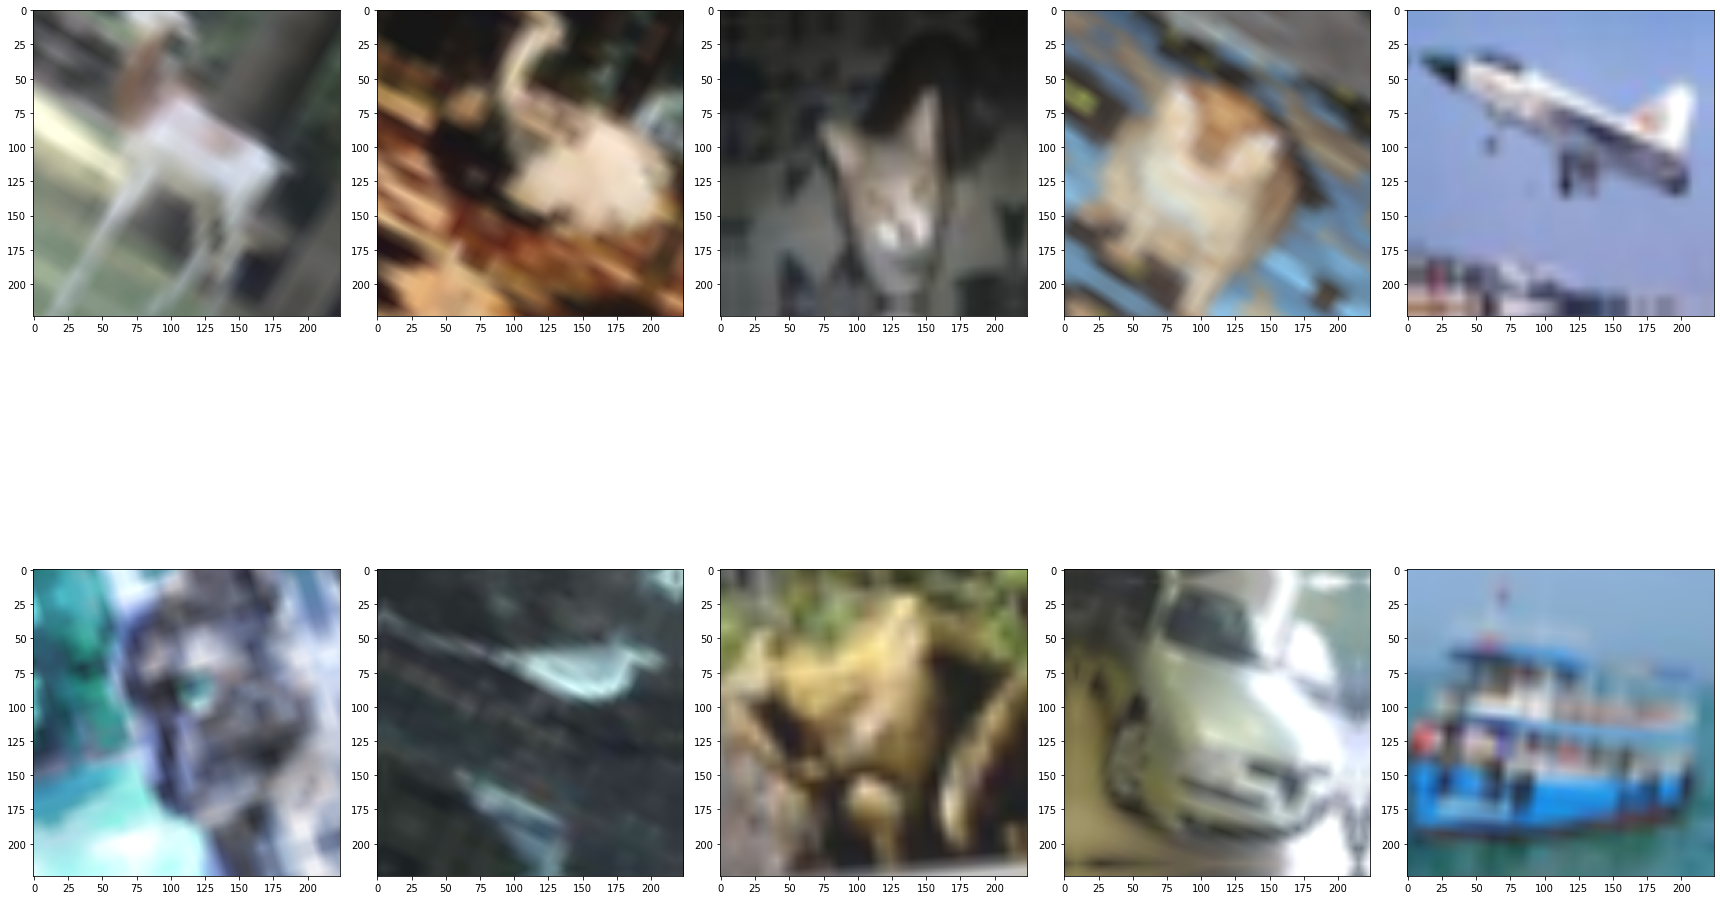

In [11]:
fig, axes = plt.subplots(2,5)
fig.set_size_inches(24,24);
image_show = next(iter(train.take(1)))[0]
for row in range(2) :
  for col in range(5):
    axes[row,col].imshow(image_show[row * 5 + col])
  plt.tight_layout();

In [12]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(96, (11, 11), strides= 4, activation='relu', input_shape=(224,224,3)),
      tf.keras.layers.MaxPool2D((3,3), strides=(2,2)),
      tf.keras.layers.Conv2D(256, (5,5), padding='same', activation='relu'),
      tf.keras.layers.MaxPool2D((3,3), strides=(2,2)),
      tf.keras.layers.Conv2D(384, (3,3), padding='same', activation='relu'),
      tf.keras.layers.Conv2D(384, (3,3), padding='same', activation='relu'),
      tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPool2D((3,3), strides=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=4096, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(units=4096, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(units=10, activation='softmax')
])

In [13]:
optimaizer = tf.optimizers.SGD(learning_rate=0.01)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

In [14]:
model.compile(optimizer=optimaizer, loss=loss, metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)      

In [ ]:
history = model.fit(train, 
          validation_data = test,
          steps_per_epoch = steps_per_epoch, 
          epochs = 40)

Epoch 1/40
391/391 [==============================] - 371s 859ms/step - loss: 2.2850 - accuracy: 0.1235 - val_loss: 2.0801 - val_accuracy: 0.2462
Epoch 2/40
391/391 [==============================] - 337s 857ms/step - loss: 2.1080 - accuracy: 0.2176 - val_loss: 1.8957 - val_accuracy: 0.3134
Epoch 3/40
391/391 [==============================] - 337s 858ms/step - loss: 1.9615 - accuracy: 0.2831 - val_loss: 1.8097 - val_accuracy: 0.3467
Epoch 4/40
391/391 [==============================] - 337s 858ms/step - loss: 1.8269 - accuracy: 0.3390 - val_loss: 1.6592 - val_accuracy: 0.3954
Epoch 5/40
391/391 [==============================] - 337s 859ms/step - loss: 1.7017 - accuracy: 0.3853 - val_loss: 1.5201 - val_accuracy: 0.4496
Epoch 6/40
391/391 [==============================] - 336s 855ms/step - loss: 1.6089 - accuracy: 0.4162 - val_loss: 1.4571 - val_accuracy: 0.4832
Epoch 7/40
391/391 [==============================] - 336s 856ms/step - loss: 1.5545 - accuracy: 0.4390 - val_loss: 1.3797 -

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [1]:
model.evaluate(test)

NameError: ignored

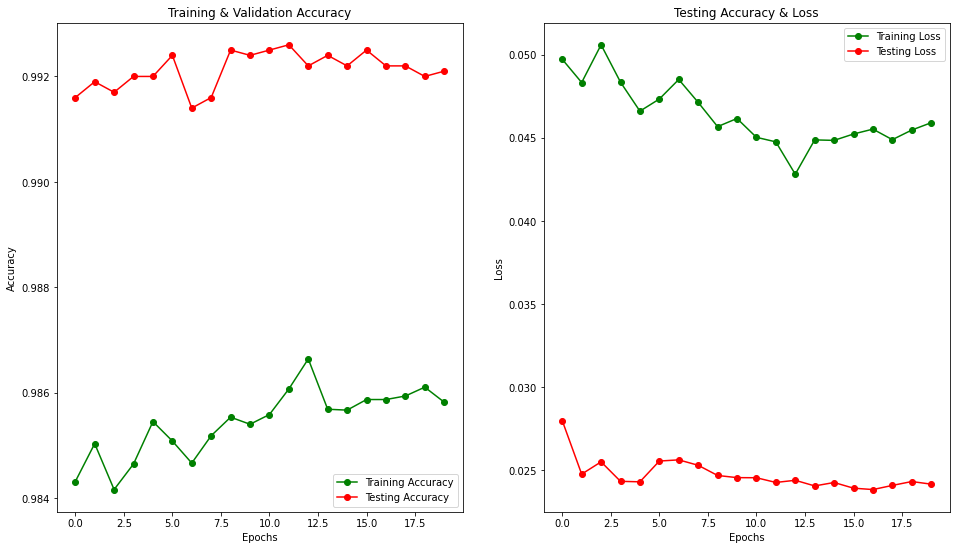

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(test_images / 255.)



In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd 
import seaborn as sns

In [ ]:
classes = ["Class " + str(i) for i in range(10) ]
print(classification_report(test_labels_orig, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       980
     Class 1       0.99      1.00      1.00      1135
     Class 2       0.99      1.00      0.99      1032
     Class 3       0.99      1.00      0.99      1010
     Class 4       0.99      0.99      0.99       982
     Class 5       0.99      0.99      0.99       892
     Class 6       0.99      0.99      0.99       958
     Class 7       0.99      0.99      0.99      1028
     Class 8       1.00      0.98      0.99       974
     Class 9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
cm = confusion_matrix(test_labels_orig,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(10)] , columns = [i for i in range(10)])

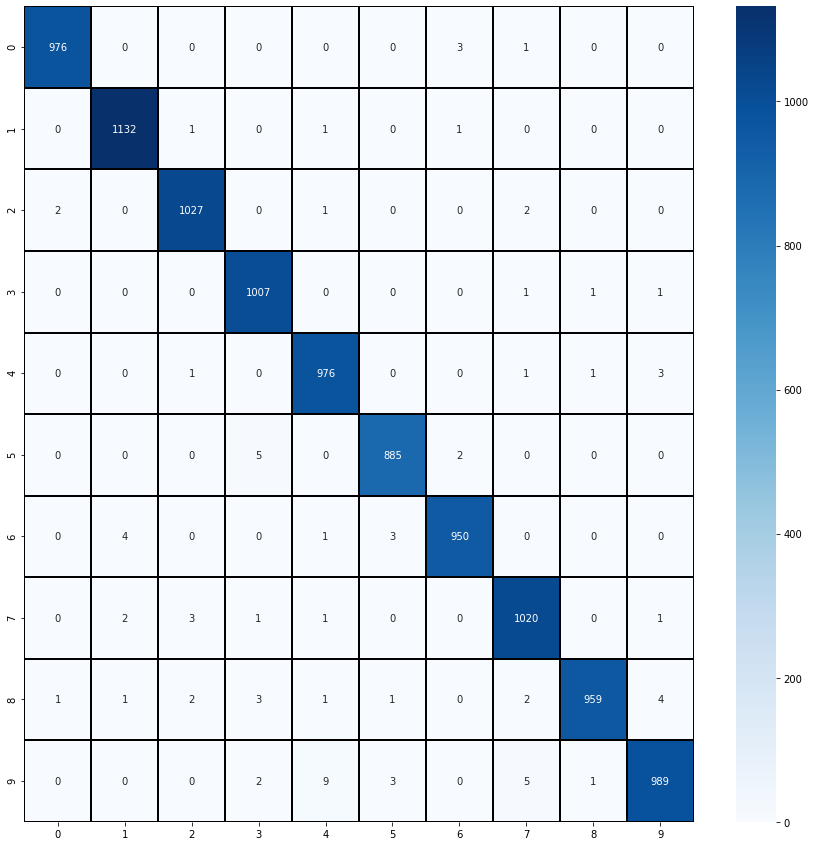

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')